In [1]:
!python -V

Python 3.11.7


In [2]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [3]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [4]:
df = pd.read_parquet(r'./data/yellow_tripdata_2023-01.parquet')

In [25]:
df.head()

df["lpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
df["lpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])
        
df['duration'] = df["lpep_dropoff_datetime"] - df["lpep_pickup_datetime"] 
        
df.duration = df.duration.apply(lambda x : x.total_seconds()/60)

In [27]:
df.duration.std()

42.594351241920904

In [36]:
df.duration.describe(percentiles = [0.95,0.98,0.99]).round()

count    3066766.0
mean          16.0
std           43.0
min          -29.0
50%           12.0
95%           36.0
98%           49.0
99%           57.0
max        10029.0
Name: duration, dtype: float64

In [37]:
dff = df[(df.duration >=1) & (df.duration <=60)]

In [40]:
dff.count()[0]/df.count()[0]

/tmp/ipykernel_2532/3519888148.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dff.count()[0]/df.count()[0]
/tmp/ipykernel_2532/3519888148.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dff.count()[0]/df.count()[0]


0.9812202822125979

In [41]:
dff.duration.describe().round()

count    3009173.0
mean          14.0
std           10.0
min            1.0
25%            7.0
50%           12.0
75%           18.0
max           60.0
Name: duration, dtype: float64

In [6]:
len(df.columns)

19

In [42]:
def read_dataframe(file_name):
    df = pd.read_parquet(file_name)
    df["lpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
    df["lpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])
    
    df['duration'] = df["lpep_dropoff_datetime"] - df["lpep_pickup_datetime"] 
    
    df.duration = df.duration.apply(lambda x : x.total_seconds()/60)
    
    df = df[(df.duration >=1) & (df.duration <= 60)]
    
    categorical = ["PULocationID","DOLocationID"]
    
    numerical = ["trip_distance"]
    
    df[categorical] = df[categorical].astype(str)
    df["PU_DO"] = df["PULocationID"] +"_" + df["DOLocationID"]

    return df




In [43]:
df_train = read_dataframe(r'./data/yellow_tripdata_2023-01.parquet')
df_val = read_dataframe(r'./data/yellow_tripdata_2023-02.parquet')

/tmp/ipykernel_2532/55724668.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train.duration)
/home/ubuntu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='duration', ylabel='Density'>

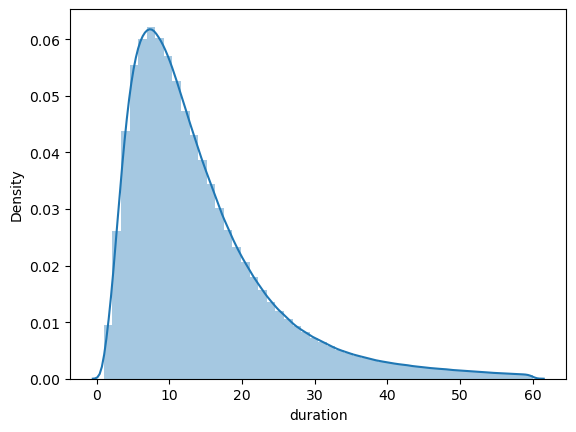

In [17]:
sns.distplot(df_train.duration)

In [44]:
df_train.duration.describe().round()

count    3009173.0
mean          14.0
std           10.0
min            1.0
25%            7.0
50%           12.0
75%           18.0
max           60.0
Name: duration, dtype: float64

In [45]:
df_train.duration.describe(percentiles = [0.95,0.98,0.99]).round()

count    3009173.0
mean          14.0
std           10.0
min            1.0
50%           12.0
95%           35.0
98%           44.0
99%           50.0
max           60.0
Name: duration, dtype: float64

In [46]:
df_train.duration.std()

9.939385620145579

In [14]:
len(df_train),len(df_val)

(3009173, 2855951)

In [11]:
df_val

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,lpep_pickup_datetime,lpep_dropoff_datetime,duration,PU_DO
0,1,2023-02-01 00:32:53,2023-02-01 00:34:34,2.0,0.30,1.0,N,142,163,2,...,0.00,0.0,1.0,9.40,2.5,0.00,2023-02-01 00:32:53,2023-02-01 00:34:34,1.683333,142_163
3,1,2023-02-01 00:29:33,2023-02-01 01:01:38,0.0,18.80,1.0,N,132,26,1,...,0.00,0.0,1.0,74.65,0.0,1.25,2023-02-01 00:29:33,2023-02-01 01:01:38,32.083333,132_26
4,2,2023-02-01 00:12:28,2023-02-01 00:25:46,1.0,3.22,1.0,N,161,145,1,...,3.30,0.0,1.0,25.30,2.5,0.00,2023-02-01 00:12:28,2023-02-01 00:25:46,13.300000,161_145
5,1,2023-02-01 00:52:40,2023-02-01 01:07:18,1.0,5.10,1.0,N,148,236,1,...,5.35,0.0,1.0,32.25,2.5,0.00,2023-02-01 00:52:40,2023-02-01 01:07:18,14.633333,148_236
6,1,2023-02-01 00:12:39,2023-02-01 00:40:36,1.0,8.90,1.0,N,137,244,1,...,3.50,0.0,1.0,50.00,2.5,0.00,2023-02-01 00:12:39,2023-02-01 00:40:36,27.950000,137_244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2913950,2,2023-02-28 23:46:00,2023-03-01 00:05:00,NaN,4.65,NaN,None,249,140,0,...,4.84,0.0,1.0,29.06,NaN,NaN,2023-02-28 23:46:00,2023-03-01 00:05:00,19.000000,249_140
2913951,2,2023-02-28 23:26:02,2023-02-28 23:37:10,NaN,2.47,NaN,None,186,79,0,...,2.65,0.0,1.0,20.31,NaN,NaN,2023-02-28 23:26:02,2023-02-28 23:37:10,11.133333,186_79
2913952,2,2023-02-28 23:24:00,2023-02-28 23:38:00,NaN,3.49,NaN,None,158,143,0,...,0.00,0.0,1.0,21.64,NaN,NaN,2023-02-28 23:24:00,2023-02-28 23:38:00,14.000000,158_143
2913953,2,2023-02-28 23:03:00,2023-02-28 23:10:00,NaN,2.13,NaN,None,79,162,0,...,2.63,0.0,1.0,20.19,NaN,NaN,2023-02-28 23:03:00,2023-02-28 23:10:00,7.000000,79_162


In [188]:
df['duration'].iloc[0].total_seconds()/60

KeyError: 'duration'

In [189]:
#df = df[df.trip_type == 2]

In [190]:
sns.distplot(df.duration)

AttributeError: 'DataFrame' object has no attribute 'duration'

In [191]:
df.duration.describe(percentiles = [0.95,0.98,0.99])

AttributeError: 'DataFrame' object has no attribute 'duration'

In [192]:
df_val

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration,PU_DO
0,2,2021-02-01 00:34:03,2021-02-01 00:51:58,N,1.0,130,205,5.0,3.66,14.00,...,10.00,0.0,None,0.3,25.30,1.0,1.0,0.00,17.916667,130_205
1,2,2021-02-01 00:04:00,2021-02-01 00:10:30,N,1.0,152,244,1.0,1.10,6.50,...,0.00,0.0,None,0.3,7.80,2.0,1.0,0.00,6.500000,152_244
2,2,2021-02-01 00:18:51,2021-02-01 00:34:06,N,1.0,152,48,1.0,4.93,16.50,...,0.00,0.0,None,0.3,20.55,2.0,1.0,2.75,15.250000,152_48
3,2,2021-02-01 00:53:27,2021-02-01 01:11:41,N,1.0,152,241,1.0,6.70,21.00,...,0.00,0.0,None,0.3,22.30,2.0,1.0,0.00,18.233333,152_241
4,2,2021-02-01 00:57:46,2021-02-01 01:06:44,N,1.0,75,42,1.0,1.89,8.50,...,2.45,0.0,None,0.3,12.25,1.0,1.0,0.00,8.966667,75_42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64567,2,2021-02-28 22:19:00,2021-02-28 22:29:00,None,NaN,129,7,NaN,2.63,10.04,...,0.00,0.0,None,0.3,10.34,NaN,NaN,NaN,10.000000,129_7
64568,2,2021-02-28 23:18:00,2021-02-28 23:27:00,None,NaN,116,166,NaN,1.87,8.33,...,1.89,0.0,None,0.3,10.52,NaN,NaN,NaN,9.000000,116_166
64569,2,2021-02-28 23:44:00,2021-02-28 23:58:00,None,NaN,74,151,NaN,2.40,12.61,...,0.00,0.0,None,0.3,12.91,NaN,NaN,NaN,14.000000,74_151
64570,2,2021-02-28 23:07:00,2021-02-28 23:14:00,None,NaN,42,42,NaN,1.11,11.95,...,0.00,0.0,None,0.3,15.00,NaN,NaN,NaN,7.000000,42_42


In [193]:
sns.distplot(df.duration)

AttributeError: 'DataFrame' object has no attribute 'duration'

In [194]:
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[us]
lpep_dropoff_datetime    datetime64[us]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
dtype: object

In [47]:
df_train.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee',
       'lpep_pickup_datetime', 'lpep_dropoff_datetime', 'duration', 'PU_DO'],
      dtype='object')

In [48]:
categorical = ['PULocationID', 'DOLocationID']#["PULocationID","DOLocationID"]
    
numerical = ["trip_distance"]

dv = DictVectorizer()
train_dicts = df_train[categorical].to_dict(orient = "records")
X_train = dv.fit_transform(train_dicts)


val_dicts = df_val[categorical].to_dict(orient = "records")

X_val = dv.transform(val_dicts)





In [51]:
X_val

<2855951x515 sparse matrix of type '<class 'numpy.float64'>'
	with 5711894 stored elements in Compressed Sparse Row format>

In [52]:
target = "duration"

y_train = df_train[target].values
y_val = df_val[target].values




In [54]:
#lr = Lasso(0.001)
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_train)
mean_squared_error(y_train,y_pred,squared  = False)

7.649261927665777

In [53]:
#lr = Lasso(0.001)
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_val)
mean_squared_error(y_val,y_pred,squared  = False)

7.811817548344513

In [203]:
!ls

data  duration-prediction.ipynb


In [205]:
with open('models/lasso.bin','wb') as f_out:
    pickle.dump((dv,lr),f_out)

/tmp/ipykernel_5224/3026314470.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred,label = "Predicted")
/home/ubuntu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_5224/3026314470.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level functi

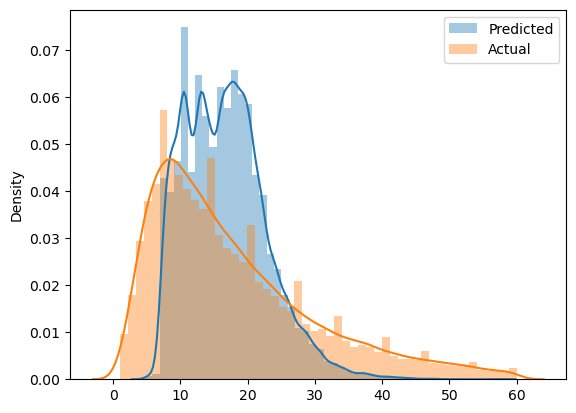

In [181]:
sns.distplot(y_pred,label = "Predicted")
sns.distplot(y_val,label = "Actual")
plt.legend()